In [2]:
import joblib
import os

# Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load Processed Dataset / Trained Model / Processes
Will load any completed processes, datasets, trained model in the case of Kernel Crash

In [3]:
X_train_scaled_loaded = joblib.load('00_dataset/with_stopwords/data/X_train_scaled.joblib')
X_test_scaled_loaded = joblib.load('00_dataset/with_stopwords/data/X_test_scaled.joblib')
X_val_scaled_loaded = joblib.load('00_dataset/with_stopwords/data/X_val_scaled.joblib')

y_train_loaded = joblib.load('00_dataset/with_stopwords/data/y_train.joblib')
y_test_loaded = joblib.load('00_dataset/with_stopwords/data/y_test.joblib')
y_val_loaded = joblib.load('00_dataset/with_stopwords/data/y_val.joblib')

X_train_smote_loaded = joblib.load('00_dataset/with_stopwords/data/X_train_smote.joblib')
y_train_smote_loaded = joblib.load('00_dataset/with_stopwords/data/y_train_smote.joblib')

In [ ]:
print(X_train_scaled_loaded.index.equals(y_train_loaded.index))
print(X_test_scaled_loaded.index.equals(y_test_loaded.index))
print(X_val_scaled_loaded.index.equals(y_val_loaded.index))
print(X_train_smote_loaded.index.equals(y_train_smote_loaded.index))

# Loading Datasets
Dataset that have gone through pre-processing and feature enginnering

In [ ]:
def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Initial memory usage: {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and col_type != 'category':
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type).startswith('int'):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization: {end_mem:.2f} MB')
    print(f'Reduced by {(start_mem - end_mem) / start_mem:.1%}')

    return df

In [ ]:
chunk_size = 100000
chunks_train = pd.read_csv("00_dataset/with_stopwords/train_features_sw.csv", chunksize=chunk_size, low_memory=False)
chunks_test = pd.read_csv("00_dataset/with_stopwords/test_features_sw.csv", chunksize=chunk_size, low_memory=False)
chunks_val = pd.read_csv("00_dataset/with_stopwords/val_features_sw.csv", chunksize=chunk_size, low_memory=False)

df_trainChunks = [reduce_memory(chunk_train) for chunk_train in chunks_train]
df_train = pd.concat(df_trainChunks, axis=0)

df_testChunks = [reduce_memory(chunk_test) for chunk_test in chunks_test]
df_test = pd.concat(df_testChunks, axis=0)

df_valChunks = [reduce_memory(chunk_val) for chunk_val in chunks_val]
df_val = pd.concat(df_valChunks, axis=0)

In [ ]:
df_train.head()

In [ ]:
df_train.head()

In [ ]:
df_val.head()

In [ ]:
train_nan_counts = df_train.isna().sum()
print("NaN values in train set:\n", train_nan_counts[train_nan_counts > 0])
test_nan_counts = df_test.isna().sum()
print("NaN values in test set:\n", test_nan_counts[test_nan_counts > 0])
val_nan_counts = df_val.isna().sum()
print("NaN values in test set:\n", val_nan_counts[val_nan_counts > 0])

# Splitting Dataset

In [ ]:
# Separate into X and y
X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]

X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

X_val = df_val.drop(columns=["label"])
y_val = df_val["label"]

In [ ]:
# Check class distribution after split
print("Train Class Distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation Class Distribution:\n", y_val.value_counts(normalize=True))
print("\nTest Class Distribution:\n", y_test.value_counts(normalize=True))

# Feature Scaling

In [ ]:
# Feature Scaling
ct_mms = ColumnTransformer(transformers=[('min_max_scaler', MinMaxScaler(), ['sentiment_score', 'vader_score', 'review_length', 'exclamation_count', 'question_count', 'uppercase_ratio', 'duplicate_word_count', 'emoji_count', 'avg_word_length'])], remainder='passthrough')
X_train_scaled = ct_mms.fit_transform(X_train)
X_test_scaled = ct_mms.transform(X_test)
X_val_scaled = ct_mms.transform(X_val)

In [ ]:
feature_names = ct_mms.get_feature_names_out()

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index )
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=feature_names, index=X_val.index)

In [ ]:
# Save scaled DataFrames
joblib.dump(X_train_scaled_df, '00_dataset/with_stopwords/data/X_train_scaled.joblib')
joblib.dump(X_test_scaled_df, '00_dataset/with_stopwords/data/X_test_scaled.joblib')
joblib.dump(X_val_scaled_df, '00_dataset/with_stopwords/data/X_val_scaled.joblib')

joblib.dump(y_train, '00_dataset/with_stopwords/data/y_train.joblib')
joblib.dump(y_test, '00_dataset/with_stopwords/data/y_test.joblib')
joblib.dump(y_val, '00_dataset/with_stopwords/data/y_val.joblib')

# Save the ColumnTransformer object for future transformations
joblib.dump(ct_mms, '00_dataset/with_stopwords/process/column_transformer.joblib')

In [ ]:
print("Training DataFrame:")
print(X_train.shape)
print(X_train_scaled.shape)

print("Testing DataFrame:")
print(X_test.shape)
print(X_test_scaled.shape)

print("Validatign DataFrame:")
print(X_val.shape)
print(X_val_scaled.shape)

# Testing Logistic Regression

In [ ]:
lr = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000, random_state=42)

lr.fit(X_train_scaled, y_train)

In [ ]:
joblib.dump(lr, '00_dataset/with_stopwords/model/lr_saga_scaled.joblib')

In [ ]:
svm = SVC(class_weight='balanced', kernel='linear', max_iter=1000, random_state=42)

svm.fit(X_train_scaled, y_train)

In [ ]:
joblib.dump(svm, '00_dataset/with_stopwords/model/svm_linear_scaled.joblib')

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_loaded, y_train_loaded)

In [ ]:
# Save smote DataFrames
joblib.dump(X_train_smote, '00_dataset/with_stopwords/data/X_train_smote.joblib')
joblib.dump(y_train_smote, '00_dataset/with_stopwords/data/y_train_smote.joblib')

In [ ]:
lr_smote = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000, random_state=42)

lr_smote.fit(X_train_smote, y_train_smote)

In [ ]:
joblib.dump(lr_smote, '00_dataset/with_stopwords/model/lr_saga_smote.joblib')

In [ ]:
svm_smote = SVC(class_weight='balanced', kernel='linear', max_iter=1000, random_state=42)

svm_smote.fit(X_train_smote, y_train_smote)

In [ ]:
joblib.dump(lr_smote, '00_dataset/with_stopwords/model/svm_linear_smote.joblib')

In [7]:
# Set batch size
batch_size = 10000  # Adjust based on memory

# Initialize the Naïve Bayes model
nb_smote = MultinomialNB(class_prior=[0.5, 0.5])

# Train in batches using partial_fit
classes = np.unique(y_train_smote_loaded)  # Get all class labels
for i in range(0, len(X_train_smote_loaded), batch_size):
    X_batch = X_train_smote_loaded[i:i+batch_size]
    y_batch = y_train_smote_loaded[i:i+batch_size]
    
    if i == 0:
        # First batch: specify classes
        nb_smote.partial_fit(X_batch, y_batch, classes=classes)
    else:
        nb_smote.partial_fit(X_batch, y_batch)

In [ ]:
nb = MultinomialNB(class_prior=[0.5, 0.5])
nb.fit(X_train_scaled_loaded, y_train_loaded)

In [ ]:
dt = DecisionTreeClassifier(max_depth=10,  # Limits tree depth to prevent overfitting
                            min_samples_split=10,  # Minimum samples needed to split a node
                            class_weight="balanced",  # Handles imbalanced dataset
                            random_state=42)

dt.fit(X_train_scaled_loaded,y_train_loaded)

# Evaluate Models

In [ ]:
lr_saga_scaled_loaded = joblib.load('00_dataset/with_stopwords/model/lr_saga_scaled.joblib')
svm_linear_scaled_loaded = joblib.load('00_dataset/with_stopwords/model/svm_linear_scaled.joblib')

lr_saga_smote_loaded = joblib.load('00_dataset/with_stopwords/model/lr_saga_smote.joblib')
svm_linear_smote_loaded = joblib.load('00_dataset/with_stopwords/model/svm_linear_smote.joblib')

In [8]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate a model's performance and display the confusion matrix, ROC AUC for both classes, and overall ROC AUC.
    Handles cases where predict_proba is not available.
    """
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate performance
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Check if predict_proba is available
    if hasattr(model, "predict_proba"):
        # Get predicted probabilities for both classes
        y_proba = model.predict_proba(X_test)

        # Calculate ROC AUC for both classes
        roc_auc_class_0 = roc_auc_score(y_test, y_proba[:, 0])  # ROC AUC for class 0
        roc_auc_class_1 = roc_auc_score(y_test, y_proba[:, 1])  # ROC AUC for class 1
        roc_auc_overall = roc_auc_score(y_test, y_proba[:, 1])  # Overall ROC AUC

        print("ROC AUC for Class 0:", roc_auc_class_0)
        print("ROC AUC for Class 1:", roc_auc_class_1)
        print("Overall ROC AUC:", roc_auc_overall)

    elif hasattr(model, "decision_function"):
        # Use decision scores if predict_proba is not available
        decision_scores = model.decision_function(X_test)
        roc_auc_overall = roc_auc_score(y_test, decision_scores)
        print("ROC AUC (using decision scores):", roc_auc_overall)

    else:
        # If neither predict_proba nor decision_function is available
        print("ROC AUC cannot be calculated because the model does not support predict_proba or decision_function.")

In [ ]:
evaluate_model(lr_saga_scaled_loaded, X_val_scaled_loaded, y_val_loaded)

In [ ]:
evaluate_model(lr_saga_smote_loaded, X_val_scaled_loaded, y_val_loaded)

In [ ]:
evaluate_model(svm_linear_scaled_loaded, X_val_scaled_loaded, y_val_loaded)

In [ ]:
evaluate_model(svm_linear_smote_loaded, X_val_scaled_loaded, y_val_loaded)

In [ ]:
evaluate_model(nb, X_val_scaled_loaded, y_val_loaded)

Accuracy: 0.689790618939618
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.70      0.80     52802
           1       0.24      0.62      0.34      8044

    accuracy                           0.69     60846
   macro avg       0.58      0.66      0.57     60846
weighted avg       0.83      0.69      0.74     60846



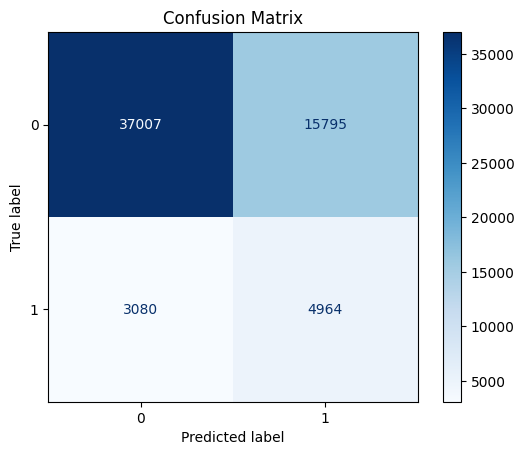

ROC AUC for Class 0: 0.280343180779641
ROC AUC for Class 1: 0.719656819220359
Overall ROC AUC: 0.719656819220359


In [10]:
evaluate_model(nb_smote, X_val_scaled_loaded, y_val_loaded)